In [2]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from get_metrics import *
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

print("Libraries imported")

Libraries imported


In [3]:
datadir = '/content/drive/MyDrive/Project/Dataset'
modeldir = '/content/drive/MyDrive/Project/Models'
trainingset = datadir+'/train/'
testingset = datadir+'/test/'

img_size = (320,320)
batch_size = 8

In [4]:
mean1, std1 = [0.3017, 0.3017, 0.3017], [0.1913, 0.1913, 0.1913]
mean2, std2 = [0.3176, 0.3176, 0.3176], [0.1881, 0.1881, 0.1881]

data_transforms = {
    'train': transforms.Compose([
                                 transforms.Resize(img_size),
                           transforms.RandomHorizontalFlip(),
                           transforms.RandomRotation(10),
                           transforms.ToTensor(),
                           transforms.Normalize(mean = mean1, 
                                                  std = std1)
    ]),
    'test': transforms.Compose([
                                transforms.Resize(img_size),
                           transforms.ToTensor(),
                           transforms.Normalize(mean = mean2, 
                                                  std = std2)
    ]),
                   }

print("Initializing Datasets and Dataloaders...\n")

image_datasets = {'train' : datasets.ImageFolder(trainingset, data_transforms['train']), 
                  'test' : datasets.ImageFolder(testingset, data_transforms['test'])}

dataloaders = {'train' : torch.utils.data.DataLoader(image_datasets['train'], 
                                                     batch_size = batch_size, shuffle = True,
                                                     num_workers=4, pin_memory=True),
               'test' : torch.utils.data.DataLoader(image_datasets['test'], 
                                                     batch_size = batch_size, shuffle = True,
                                                     num_workers=4, pin_memory=True)}

device = torch.device("cuda:0")
dataset_sizes = {'train' : len(image_datasets['train']),
                 'test' : len(image_datasets['test'])}
print("Initialized!")

Initializing Datasets and Dataloaders...

Initialized!


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [5]:
# Class names convert to index
image_datasets['train'].class_to_idx
class_names=image_datasets['train'].classes
print(">>Class Names: {}\n".format(image_datasets['train'].classes))
print(">>Class Index: {}\n".format(image_datasets['train'].class_to_idx))
print(">>Number of images in training={}\n".format(dataset_sizes['train']))
print(">>Number of images in test={}\n".format(dataset_sizes['test']))
print("    Number of steps for training set={}\n".format(len(dataloaders['train'])))
print("    Number of steps for test set={}\n".format(len(dataloaders['test']))) 

>>Class Names: ['abnormal', 'normal']

>>Class Index: {'abnormal': 0, 'normal': 1}

>>Number of images in training=8379

>>Number of images in test=563

    Number of steps for training set=1048

    Number of steps for test set=71



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


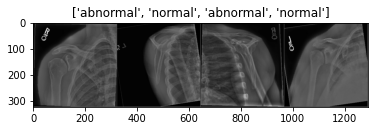

In [6]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array(mean1)
    std = np.array(std1)
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))
inputs = [inputs[x] for x in [0,1,2,3]]
classes = [classes[x] for x in [0,1,2,3]]
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

**Building the Ensemble Learning Model**

In [7]:
class SpinalNet_DenseNet_201(nn.Module):
  def __init__(self):
    super(SpinalNet_DenseNet_201, self).__init__()

    self.fc_spinal_layer1 = nn.Sequential(
        nn.Dropout(p=0.5),
        nn.Linear(960, 240),
        nn.BatchNorm1d(240),
        nn.ReLU(inplace=True),)
    self.fc_spinal_layer2 = nn.Sequential(
        nn.Dropout(p=0.5),
        nn.Linear(960+240, 240),
        nn.BatchNorm1d(240),
        nn.ReLU(inplace=True),)
    self.fc_spinal_layer3 = nn.Sequential(
        nn.Dropout(p=0.5),
        nn.Linear(960+240, 240),
        nn.BatchNorm1d(240),
        nn.ReLU(inplace=True),)
    self.fc_spinal_layer4 = nn.Sequential(
        nn.Dropout(p=0.5),
        nn.Linear(960+240, 240),
        nn.BatchNorm1d(240),
        nn.ReLU(inplace=True),)
    self.fc_out = nn.Sequential(
        nn.Dropout(p=0.5),
        nn.Linear(240*4, 2),
        nn.Sigmoid(),)
  
  def forward(self, x):
    x1 = self.fc_spinal_layer1(x[:, 0:960])
    x2 = self.fc_spinal_layer2(torch.cat([x[:, 960:2*960], x1], dim=1))
    x3 = self.fc_spinal_layer3(torch.cat([x[:, 0:960], x2], dim=1))
    x4 = self.fc_spinal_layer4(torch.cat([x[:, 960:2*960], x3], dim=1))

    x = torch.cat([x1, x2], dim=1)
    x = torch.cat([x, x3], dim=1)
    x = torch.cat([x, x4], dim=1)

    x = self.fc_out(x)
    return x

In [8]:
class SpinalNet_ResNext_50(nn.Module):
  def __init__(self):
    super(SpinalNet_ResNext_50, self).__init__()

    self.fc_spinal_layer1 = nn.Sequential(
        nn.Linear(1024, 20),
        nn.ReLU(inplace=True),)
    self.fc_spinal_layer2 = nn.Sequential(
        nn.Linear(1024+20, 20),
        nn.ReLU(inplace=True),)
    self.fc_spinal_layer3 = nn.Sequential(
        nn.Linear(1024+20, 20),
        nn.ReLU(inplace=True),)
    self.fc_spinal_layer4 = nn.Sequential(
        nn.Linear(1024+20, 20),
        nn.ReLU(inplace=True),)
    self.fc_out = nn.Sequential(
        nn.Linear(20*4, 2),
        nn.Sigmoid())
    
  def forward(self, x): 
    x1 = self.fc_spinal_layer1(x[:, 0:1024])
    x2 = self.fc_spinal_layer2(torch.cat([x[:, 1024:2*1024], x1], dim=1))
    x3 = self.fc_spinal_layer3(torch.cat([x[:, 0:1024], x2], dim=1))
    x4 = self.fc_spinal_layer4(torch.cat([x[:, 1024:2*1024], x3], dim=1))   

    x = torch.cat([x1, x2], dim=1)
    x = torch.cat([x, x3], dim=1)
    x = torch.cat([x, x4], dim=1)

    x = self.fc_out(x)

    return x

In [9]:
model_1 = models.densenet201(pretrained=False)
model_3 = models.densenet169(pretrained=False)
model_4 = models.resnext50_32x4d(pretrained=False)

In [10]:
model_1.classifier = SpinalNet_DenseNet_201()
model_3.classifier = nn.Sequential(nn.Linear(1664,2), nn.Sigmoid())
model_4.fc = SpinalNet_ResNext_50()

In [11]:
model_1.load_state_dict(torch.load(modeldir+'/DenseNet201SP.pth'))
model_3.load_state_dict(torch.load(modeldir+'/DenseNet169FC.pth'))
model_4.load_state_dict(torch.load(modeldir+'/ResNeXt50SP.pth'))

<All keys matched successfully>

In [12]:
model_1=model_1.to(device)
model_3=model_3.to(device)
model_4=model_4.to(device)

In [13]:
model_1.classifier.fc_out=nn.Linear(960,960)
model_3.classifier = nn.Linear(1664, 1664)
model_4.fc.fc_out = nn.Linear(80,80)

In [14]:
for param in model_1.parameters():
    param.requires_grad_(False)
    
for param in model_3.parameters():
    param.requires_grad_(False)

for param in model_4.parameters():
    param.requires_grad_(False)

In [15]:
class SubEnsemble(nn.Module):
  def __init__(self):
    super(SubEnsemble, self).__init__()

    self.modelA = model_4
    self.modelB = model_3
    self.modelC = model_1

    self.hidden = nn.Linear(2704, 2704)
    self.classifier = nn.Linear(2704, 2)

  def forward(self, x):

    x1 = self.modelA(x.clone())
    x1 = x1.view(x1.size(0), -1)
    x2 = self.modelB(x)
    x2 = x2.view(x2.size(0), -1)
    x3 = self.modelC(x)
    x3 = x3.view(x3.size(0), -1)

    x = torch.cat((x1,x2,x3), dim=1)
    x = self.hidden(torch.softmax(x, dim=1))
    x = self.classifier(torch.sigmoid(x))

    return x

In [16]:
model_2 = SubEnsemble()
model_2.load_state_dict(torch.load(modeldir+'/EL1.pth'))
model_2 = model_2.to(device)

In [17]:
model_1.eval()
model_2.eval()
model_3.eval()
model_4.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

In [18]:
get_metric.test_model_el2(model_1,model_3,model_2,model_4,device,dataloaders['test'])

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Correct Prediction: 463  Total Images: 563
Test Accuracy = 0.822380


In [19]:
actuals, predictions = get_metric.test_label_predictions_el2(model_1,model_3,model_2,model_4,device,dataloaders['test'])

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [20]:
get_metric.get_classification_report(actuals, predictions)

Classification Report :
               precision    recall  f1-score   support

           0       0.83      0.81      0.82       278
           1       0.82      0.84      0.83       285

    accuracy                           0.82       563
   macro avg       0.82      0.82      0.82       563
weighted avg       0.82      0.82      0.82       563



Confusion matrix:
 [[224  54]
 [ 46 239]]


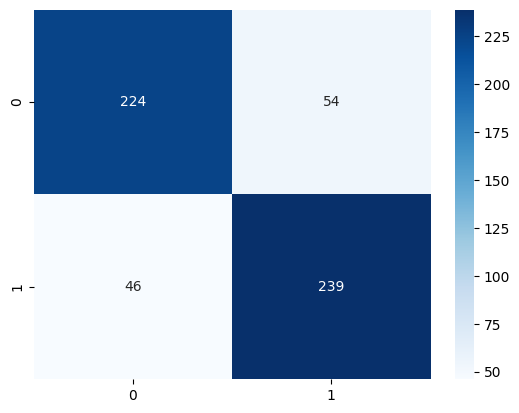

In [21]:
get_metric.get_confusion_matrix(actuals, predictions)

In [22]:

get_metric.get_cohen_kappa(actuals, predictions)

Kappa Score of this model:
 0.6445796823312542
